# Sentiment Analysis for British Airlines Reviews

In [20]:
# Standard Libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# For Web Scrapping
import requests
from bs4 import BeautifulSoup

# For Data Pre-processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer   
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

# For topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation

# For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meryem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meryem\AppData\Roaming\nltk_data...


In [1]:
# Load the amazon review dataset
df = pd.read_csv('BA_reviews.csv')
df

,Unnamed: 0,reviews
0,0,"✅ Trip Verified | Absolutely terrible, lost m..."
1,1,✅ Trip Verified | We booked premium economy r...
2,2,✅ Trip Verified | We chose Rotterdam and Lond...
3,3,✅ Trip Verified | The entire booking and ticke...
4,4,Not Verified | British Airways cancelled my ...
...,...,...
3782,3782,Flight from Heathrow to Toronto. Booked emerge...
3783,3783,LHR to HAM. Purser addresses all club passenge...
3784,3784,My son who had worked for British Airways urge...
3785,3785,London City-New York JFK via Shannon on A318 b...


## Pre-Processing 

In [2]:
df.reviews= df.reviews.str.split('|',expand=True)[1]

In [11]:
def replace(text):            # Define a function to clean the text
    text = re.sub(r'[^A-Za-z]+', ' ', str(text)) # Replaces all special characters and numericals with blanks and leaving the alphabets
    return text
# Cleaning the text in the review column
df['reviews']= df["reviews"].apply(replace)
df.head()

,Unnamed: 0,reviews
0,0,Absolutely terrible lost my luggage on both f...
1,1,We booked premium economy round trip from Pho...
2,2,We chose Rotterdam and London City airport be...
3,3,The entire booking and ticketing experience h...
4,4,British Airways cancelled my flight less than...


In [12]:
#Turning strings into lowercase
df['reviews'] = df['reviews'].str.lower()

In [13]:
#Removing punctuations
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '')

In [14]:
#Removing numbers
df['reviews'] = df['reviews'].str.replace('\d', '')

In [15]:
#Word tokenization
df["reviews"].apply(lambda x: TextBlob(x).words).head()

0    [absolutely, terrible, lost, my, luggage, on, ...
1    [we, booked, premium, economy, round, trip, fr...
2    [we, chose, rotterdam, and, london, city, airp...
3    [the, entire, booking, and, ticketing, experie...
4    [british, airways, cancelled, my, flight, less...
Name: reviews, dtype: object

In [18]:
#Removing stop words ("and," "the," "of," and "it.")
sw = stopwords.words('english')
df['reviews'] = df['reviews'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [21]:
#Lemmatization
df['reviews'] = df['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviews'].head(10)

0    absolutely terrible lost luggage flight delive...
1    booked premium economy round trip phoenix zuri...
2    chose rotterdam london city airport convenienc...
3    entire booking ticketing experience stressful ...
4    british airway cancelled flight le hour automa...
5    wanted write review could give huge thank one ...
6    check fast friendly security breeze lounge bus...
7    first time seen new club world suite seat comf...
8    flew business class doha london st march servi...
9    starting heathrow terminal check fairly easy f...
Name: reviews, dtype: object

## Topic Modeling

In [29]:
cv = CountVectorizer()
x = cv.fit_transform(df['reviews'])         # Fitting the vectorizer to the dataset

In [30]:
x

<3787x9681 sparse matrix of type '<class 'numpy.int64'>'
	with 155586 stored elements in Compressed Sparse Row format>

#### Latent Dirichlet Allocation (LDA)

In [31]:
# Function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [36]:
lda = LatentDirichletAllocation(n_components=15, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [37]:
lda.fit(x)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=15, random_state=0)

In [38]:
### Topics generated by LDA
n_top_words = 40
print("\nTopics in LDA model: ")
cv_feature_names = cv.get_feature_names_out()
print_top_words(lda, cv_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:nappy lon winning assign movement mush achieve poo surrounded uninteresting gcm restrict migrate patch owed stinking blend gain sprint ocean shelling engages maximize rebel funsize shortsighted remedied confiming reconfigured steerage familiarity boned oratory nobel suet contemplating regime disrespecting stodge runny

Topic #1:vce shouted hilton brandy yul uber fro withonce radioed distressing suprised distressed deskthey vi bewildered copiously stench pervading puke vomited alienating surround complimenting innsbruck indicates guard twelfth pic joes germ tenth parallel ana vending committed inboxes skytrax proudly strained tweeted

Topic #2:senior mr buggy kl wish sathies uni gratitude leaking exceptional lumpur kuala rbi brunei bandar unwavering gurvir dhillon singh event professionalism family journey despicable cognac handout poisoning generously salvage clarity hurdle tirelessly unfolded amid excellence inoperable toward sewage dedication sequence

In [39]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['reviews'].apply(vadersentimentanalysis)


def vader_analysis(compound):                
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,Unnamed: 0,reviews,Sentiment,Analysis
0,0,absolutely terrible lost luggage flight delive...,-0.9543,Negative
1,1,booked premium economy round trip phoenix zuri...,0.9035,Positive
2,2,chose rotterdam london city airport convenienc...,0.3818,Neutral
3,3,entire booking ticketing experience stressful ...,-0.9474,Negative
4,4,british airway cancelled flight le hour automa...,-0.7650,Negative


In [40]:
analysis = df['Analysis'].value_counts()
analysis

Analysis
Neutral     1789
Positive    1143
Negative     855
Name: count, dtype: int64

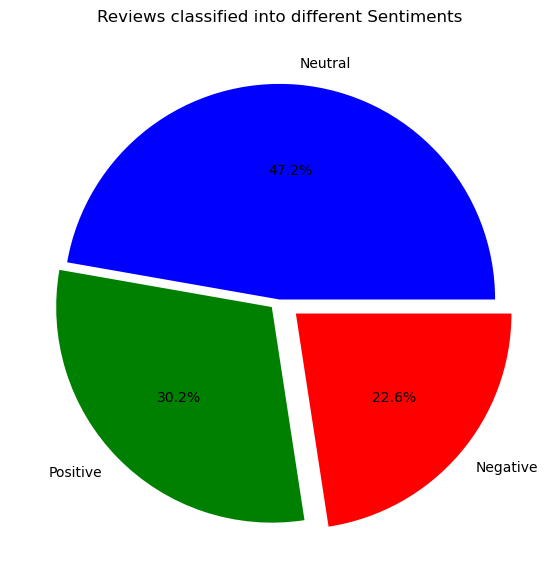

In [41]:
plt.figure(figsize=(25,7))
plt.subplot(1,3,2)
plt.title("Reviews classified into different Sentiments")
plt.pie(analysis.values, labels = analysis.index, explode = (0, 0.05, 0.1), autopct='%1.1f%%', shadow=False , colors=("blue", "green", "red"))
plt.show()

In [54]:
df.to_csv('BA_sentiment.csv', encoding='utf-8')

In [60]:
from nltk.tokenize import word_tokenize

# Concatenating all text from df
combined_text = ' '.join(df['reviews'])
tokens = word_tokenize(combined_text)
word_counts = Counter(tokens)
top_words = word_counts.most_common(35)

top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
top_words_df

,Word,Count
0,flight,5155
1,ba,3246
2,seat,2467
3,service,1932
4,london,1651
5,none,1565
6,time,1524
7,food,1338
8,crew,1285
9,british,1283


# Trying Flair

In [53]:
pip install TextClassifier

  Using cached TextClassifier-0.0.8.tar.gz (4.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [5 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 29, in <module>
    File "<frozen codecs>", line 322, in decode
  UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc4 in position 35: invalid continuation byte
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [51]:
import TextClassifier

classifier = TextClassifier.load('en-sentiment')

for index, row in df.iterrows():
    text = row['tokens']  
    sentence = Sentence(text)
    classifier.predict(sentence)
    sentiment = sentence.labels[0].value
    score = sentence.labels[0].score
    df.loc[index, 'sentiment'] = sentiment
    df.loc[index, 'score'] = score


print(df.head())

ModuleNotFoundError: No module named 'TextClassifier'

In [52]:
# Load the pre-trained sentiment analysis model
classifier = TextClassifier.load('en-sentiment')

# Iterate over each row in the DataFrame # :( its really time consuming :(
for index, row in df.iterrows():
    text = row['tokens']  
    sentence = Sentence(text)
    
    # Predict the sentiment for the current sentence
    classifier.predict(sentence)
    
    # Get the predicted sentiment and score
    sentiment = sentence.labels[0].value
    score = sentence.labels[0].score
    
    # Update the DataFrame with the sentiment and score
    df.loc[index, 'sentiment'] = sentiment
    df.loc[index, 'score'] = score

# Print the 'sentiment' column of the DataFrame
print(df['sentiment'])

NameError: name 'TextClassifier' is not defined